# Homework day 3 - Bryn Lampe

In [153]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit, jitclass, float64, prange
from sklearn.neighbors import KernelDensity
import quantecon as qe

# Inventory Dynamics


<a id='index-0'></a>

In [17]:
firm_data = [
   ('s', float64),          # restock trigger level
   ('S', float64),          # capacity
   ('mu', float64),         # shock location parameter
   ('sigma', float64)       # shock scale parameter
]


@jitclass(firm_data)
class Firm:

    def __init__(self, s=10, S=100, mu=1.0, sigma=0.5):

        self.s, self.S, self.mu, self.sigma = s, S, mu, sigma

    def update(self, x):
        "Update the state from t to t+1 given current state x."

        Z = np.random.randn()
        D = np.exp(self.mu + self.sigma * Z)
        if x <= self.s:
            return max(self.S - D, 0)
        else:
            return max(x - D, 0)

    def sim_inventory_path(self, x_init, sim_length):

        X = np.empty(sim_length)
        X[0] = x_init

        for t in range(sim_length-1):
            X[t+1] = self.update(X[t]) # when refer to a method defined in the class use self.method
        return X
    
def plot_kde(sample, ax, label):

    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

### Exercise 1

This model is asymptotically stationary, with a unique stationary
distribution.

(This is the same concept we discussed in the lecture on AR(1) processes.)

In particular, the sequence of marginal distributions $ \{\psi_t\} $
is converging to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can investigate it using simulation.

Your task is to generate and plot the sequence $ \{\psi_t\} $ at times
$ t = 10, 50, 250, 500, 750 $ based on the discussion above.

(The kernel density estimator is probably the best way to present each
distribution.)

You should see convergence, in the sense that differences between successive distributions are getting smaller.

Try different initial conditions to verify that, in the long run, the distribution is invariant across initial conditions.

/Users/bclampe/opt/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'time_periods' of function 'inventory_paths_simlation'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-198-5d28e4b80c16>", line 14:
@njit
def inventory_paths_simlation(firm, num_paths, num_samples,x_init, T, time_periods):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


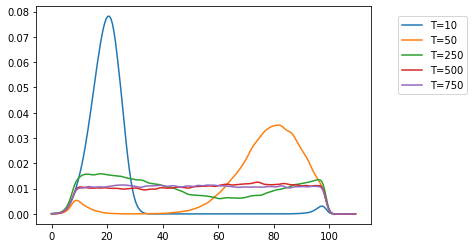

In [198]:
firm = Firm()

x_init = 50

time_periods = [10, 50, 250, 500, 750]
T = 750

num_paths = 50_000
num_samples = 5

fig, ax = plt.subplots()
                                         
@njit
def inventory_paths_simlation(firm, num_paths, num_samples,x_init, T, time_periods):
    
    sample = np.empty((num_paths, num_samples))
    
    for m in range(num_paths):
        X = firm.sim_inventory_path(x_init, T+1)
        for j in range(num_samples):
            period = time_periods[j]
            sample[m, j] = X[period]
            
    return sample

sample = inventory_paths_simlation(firm, num_paths, num_samples, x_init, T, time_periods)
            
plot_kde(sample[:,0], ax, 'T=10')
plot_kde(sample[:,1], ax, 'T=50')
plot_kde(sample[:,2], ax, 'T=250')
plot_kde(sample[:,3], ax, 'T=500')
plot_kde(sample[:,4], ax, 'T=750')


ax.legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=1)

### Exercise 2

Using simulation, calculate the probability that firms that start with
$ X_0 = 70 $ need to order twice or more in the first 50 periods.

You will need a large sample size to get an accurate reading.

In [196]:
firm = Firm()

T = 50
x_init = 50
num_paths = 1_000_000

                                    

@njit
def restock_counter(firm, num_paths, x_init, T):    
    
    restock_times = np.empty(num_paths)
    X_diff = np.empty(T)  
    
    for m in range(num_paths):
        counter = 0
        X = firm.sim_inventory_path(x_init, T+1)
        for j in range(len(X)-1):
            X_diff[j] = X[j] - X[j+1]
            if X_diff[j] < 0:
                counter += 1

        restock_times[m] = counter
        
    return restock_times


restock_times = restock_counter(firm, num_paths, x_init, T)

prob = len(restock_times[ restock_times >= 2 ])/num_paths

print(prob)

0.959619


example (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-193-377e4a71dbc2>
# --- LINE 1 --- 
# label 0

@jit

# --- LINE 2 --- 

def example(a,b):

    # --- LINE 3 --- 
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $0.3 = a + b  :: int64
    #   del b
    #   del a
    #   $0.4 = cast(value=$0.3)  :: int64
    #   del $0.3
    #   return $0.4

    return a+b




# Kesten processes

### Exercise 1

Simulate and plot 15 years of daily returns (consider each year as having 250
working days) using the GARCH(1, 1) process in [(2)](#equation-garch11v)–[(3)](#equation-garch11r).

Take $ \xi_t $ and $ \zeta_t $ to be independent and standard normal.

Set $ \alpha_0 = 0.00001, \alpha_1 = 0.1, \beta = 0.9 $ and $ \sigma_0 = 0 $.

Compare visually with the Nasdaq Composite Index returns [shown above](#ndcode).

While the time path differs, you should see bursts of high volatility.

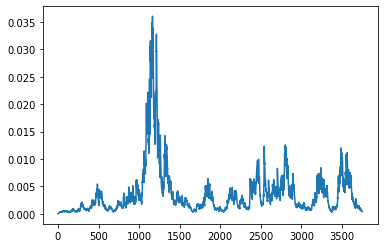

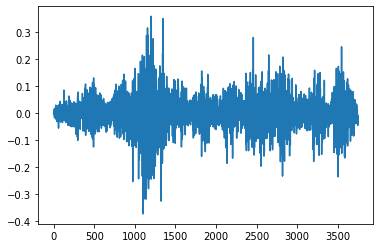

In [149]:
years = 15
days = 250

T = years * days

ξ = np.random.normal(0,1,T)
ζ = np.random.normal(0,1,T)

class SimulateGARCH:
    
    def __init__(self,α = [0.00001, 0.1],
                      β = 0.9,
                      θ_0 = 0):
        self.α = α
        self.β, self.θ_0 = β, θ_0
        
    def simulated_volatility(self, ξ,  T):
        σ = np.empty(T)
        σ[0] = self.θ_0
        
        for t in range(T-1):
            σ[t+1] = self.α[0] + σ[t] * (self.α[1] * ξ[t+1]**2 + self.β)
            
        return σ
    
    def simulated_return(self, σ, ζ, T):
        
        return_vec = np.empty(T)
        
        for t in range(T-1):
            return_vec[t+1] = np.sqrt(σ[t]) * ζ[t+1]
            
        return return_vec
            
            
            

sim_garch = SimulateGARCH()

sim_volatility = sim_garch.simulated_volatility(ξ, T)
sim_returns = sim_garch.simulated_return(sim_volatility, ζ, T)


x1 = range(T)
x2 = range(T)

fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()

ax1.plot(x1, sim_volatility)
ax2.plot(x2, sim_returns)


plt.show()






### Exercise 2

In our discussion of firm dynamics, it was claimed that [(9)](#equation-firm-dynam) is more consistent with the empirical literature than Gibrat’s law in [(8)](#equation-firm-dynam-gb).

(The empirical literature was reviewed immediately above [(9)](#equation-firm-dynam).)

In what sense is this true (or false)?

### Exercise 3

Consider an arbitrary Kesten process as given in [(1)](#equation-kesproc).

Suppose that $ \{a_t\} $ is lognormal with parameters $ (\mu,
\sigma) $.

In other words, each $ a_t $ has the same distribution as $ \exp(\mu + \sigma Z) $ when $ Z $ is standard normal.

Suppose further that $ \mathbb E \eta_t^r < \infty $ for every $ r > 0 $, as
would be the case if, say, $ \eta_t $ is also lognormal.

Show that the conditions of the Kesten–Goldie theorem are satisfied if and
only if $ \mu < 0 $.

Obtain the value of $ \alpha $ that makes the Kesten–Goldie conditions
hold.

### Exercise 4

One unrealistic aspect of the firm dynamics specified in [(9)](#equation-firm-dynam) is
that it ignores entry and exit.

In any given period and in any given market, we observe significant numbers of firms entering and exiting the market.

Empirical discussion of this can be found in a famous paper by Hugo Hopenhayn (1992, Econometrica).

In the same paper, Hopenhayn builds a model of entry and exit that
incorporates profit maximization by firms and market clearing quantities, wages and prices.

In his model, a stationary equilibrium occurs when the number of entrants
equals the number of exiting firms.

In this setting, firm dynamics can be expressed as


<a id='equation-firm-dynam-ee'></a>
$$
s_{t+1} = e_{t+1} \mathbb{1}\{s_t < \bar s\}
    + (a_{t+1} s_t + b_{t+1}) \mathbb{1}\{s_t \geq \bar s\} \tag{10}
$$

Here

- the state variable $ s_t $ is represents productivity (which is a proxy
  for output and hence firm size),  
- the IID sequence $ \{ e_t \} $ is thought of as a productivity draw for a new
  entrant and  
- the variable $ \bar s $ is a threshold value that we take as given,
  although it is determined endogenously in Hopenhayn’s model.  


The idea behind [(10)](#equation-firm-dynam-ee) is that firms stay in the market as long
as their productivity $ s_t $ remains at or above $ \bar s $.

- In this case, their productivity updates according to [(9)](#equation-firm-dynam).  


Firms choose to exit when their productivity $ s_t $ falls below $ \bar s $.

- In this case, they are replaced by a new firm with productivity
  $ e_{t+1} $.  


What can we say about dynamics?

Although [(10)](#equation-firm-dynam-ee) is not a Kesten process, it does update in the
same way as a Kesten process when $ s_t $ is large.

So perhaps its stationary distribution still has Pareto tails?

Your task is to investigate this question via simulation and rank-size plots.

The approach will be to

1. generate $ M $ draws of $ s_T $ when $ M $ and $ T $ are
  large and  
1. plot the largest 1,000 of the resulting draws in a rank-size plot.  


(The distribution of $ s_T $ will be close to the stationary distribution
when $ T $ is large.)

In the simulation, assume that

- each of $ a_t, b_t $ and $ e_t $ is lognormal,  
- the parameters are  

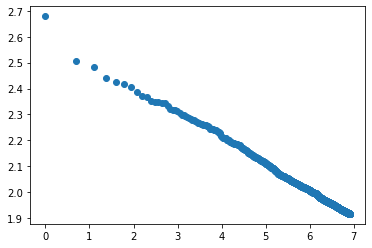

In [162]:
T = 500          # sampling date
M = 1_000_000     # number of firms


firm_data = [
   ('μ_a', float64),          
   ('σ_a', float64),         
   ('μ_b', float64),        
   ('σ_b', float64),
   ('μ_e', float64),        
   ('σ_e', float64),
   ('s_bar', float64),         
   ('s_init', float64)]


@jitclass(firm_data)
class Hopenhayn:
    
    def __init__(self,μ_a = -0.5,        # location parameter for a
                      σ_a = 0.1,        # scale parameter for a
                      μ_b = 0.0,         # location parameter for b
                      σ_b = 0.5,         # scale parameter for b
                      μ_e = 0.0,         # location parameter for e
                      σ_e = 0.5,         # scale parameter for e
                      s_bar = 1.0,       # threshold
                      s_init = 1.0):     # initial condition for each firm):
        self.μ_a, self.σ_a = μ_a, σ_a
        self.μ_b, self.σ_b = μ_b, σ_b
        self.μ_e, self.σ_e = μ_e, σ_e
        self.s_bar, self.s_init = s_bar, s_init
        
    def productivity_draws(self, T):
        a = np.exp(self.μ_a + self.σ_a * np.random.normal(0, 1, T))
        b = np.exp(self.μ_b + self.σ_b * np.random.normal(0, 1, T))
        e = np.exp(self.μ_e + self.σ_e * np.random.normal(0, 1, T))
        
        return a, b, e
        
    def firm_dynamics(self, T):
        
        s = np.empty(T)
        s[0] = self.s_init
        
        a, b, e = self.productivity_draws(T)
        
        for t in range(T-1):
            if s[t] < self.s_bar:
                s[t+1] = e[t+1]
            else:
                s[t+1] = a[t+1] * s[t] + b[t+1]
        return s[t]
        
        
hop_inst = Hopenhayn()


@njit(parallel=True)
def final_firm_size(hop_inst, M):
    
    firm_size = np.empty(M)
    
    for m in prange(M):
        firm_size[m] = hop_inst.firm_dynamics(T)
        
    return firm_size

firm_size = final_firm_size(hop_inst, M) 

firm_size = np.sort(firm_size)[::-1]
firm_size = np.log(firm_size[:1000])

x = np.log(range(1,1001,1))

fig, ax = plt.subplots()

ax.plot(x,firm_size,'o')


# Wealth dynamics

### Exercise 1

For a wealth or income distribution with Pareto tail, a higher tail index suggests lower inequality.

Indeed, it is possible to prove that the Gini coefficient of the Pareto
distribution with tail index $ a $ is $ 1/(2a - 1) $.

To the extent that you can, confirm this by simulation.

In particular, generate a plot of the Gini coefficient against the tail index
using both the theoretical value just given and the value computed from a sample via `qe.gini_coefficient`.

For the values of the tail index, use `a_vals = np.linspace(1, 10, 25)`.

Use sample of size 1,000 for each $ a $ and the sampling method for generating Pareto draws employed in the discussion of Lorenz curves for the Pareto distribution.

To the extend that you can, interpret the monotone relationship between the
Gini index and $ a $.

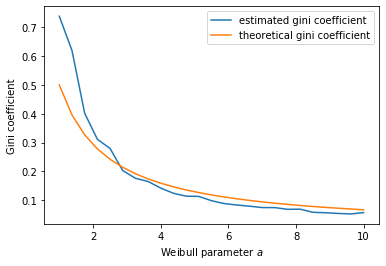

In [155]:
a_vals = np.linspace(1, 10, 25)
ginis = []
ginis_theoretical = []
n = 1000

fig, ax = plt.subplots()

for a in a_vals:
    u = np.random.uniform(size=n)
    y = u**(-1/a)
    ginis.append(qe.gini_coefficient(y))
    ginis_theoretical.append(1 - 2**(-1/a))

ax.plot(a_vals, ginis, label='estimated gini coefficient')
ax.plot(a_vals, ginis_theoretical, label='theoretical gini coefficient')
ax.legend()
ax.set_xlabel("Weibull parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()


### Exercise 2

The wealth process [(1)](#equation-wealth-dynam-ah) is similar to a [Kesten process](kesten_processes.ipynb).

This is because, according to [(2)](#equation-sav-ah), savings is constant for all wealth levels above $ \hat w $.

When savings is constant, the wealth process has the same quasi-linear
structure as a Kesten process, with multiplicative and additive shocks.

The Kesten–Goldie theorem tells us that Kesten processes have Pareto tails under a range of parameterizations.

The theorem does not directly apply here, since savings is not always constant and since the multiplicative and additive terms in [(1)](#equation-wealth-dynam-ah) are not IID.

At the same time, given the similarities, perhaps Pareto tails will arise.

To test this, run a simulation that generates a cross-section of wealth and
generate a rank-size plot.

In viewing the plot, remember that Pareto tails generate a straight line.  Is
this what you see?

For sample size and initial conditions, use

In [156]:
wealth_dynamics_data = [
    ('w_hat',  float64),    # savings parameter
    ('s_0',    float64),    # savings parameter
    ('c_y',    float64),    # labor income parameter
    ('μ_y',    float64),    # labor income paraemter
    ('σ_y',    float64),    # labor income parameter
    ('c_r',    float64),    # rate of return parameter
    ('μ_r',    float64),    # rate of return parameter
    ('σ_r',    float64),    # rate of return parameter
    ('a',      float64),    # aggregate shock parameter
    ('b',      float64),    # aggregate shock parameter
    ('σ_z',    float64),    # aggregate shock parameter
    ('z_mean', float64),    # mean of z process
    ('z_var', float64),     # variance of z process
    ('y_mean', float64),    # mean of y process
    ('R_mean', float64)     # mean of R process
]

@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1):

        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z

        # Record stationary moments
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)

        # Test a stability condition that ensures wealth does not diverge
        # to infinity.
        α = self.R_mean * self.s_0
        if α >= 1:
            raise ValueError("Stability condition failed.")

    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0,
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters

    def update_states(self, w, z):
        """
        Update one period, given current wealth w and persistent
        state z.
        """

        # Simplify names
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
        zp = a * z + b + σ_z * np.random.randn()

        # Update wealth
        y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())
        wp = y
        if w >= w_hat:
            R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
            wp += R * s_0 * w
        return wp, zp
    
@njit
def wealth_time_series(wdy, w_0, n):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: an instance of WealthDynamics
        * w_0: scalar
        * n: int


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

@njit(parallel=True)
def update_cross_section(wdy, w_distribution, shift_length=500):
    """
    Shifts a cross-section of household forward in time

    * wdy: an instance of WealthDynamics
    * w_distribution: array_like, represents current cross-section

    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where
    j = shift_length.

    Returns the new distribution.

    """
    new_distribution = np.empty_like(w_distribution)

    # Update each household
    for i in prange(len(new_distribution)):
        z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
        w = w_distribution[i]
        for t in range(shift_length-1):
            w, z = wdy.update_states(w, z)
        new_distribution[i] = w
    return new_distribution

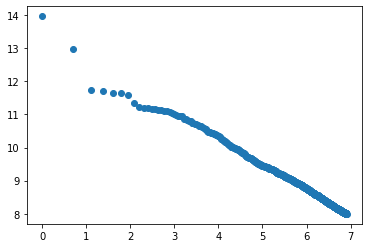

In [158]:
wdy = WealthDynamics()

num_households = 250_000
T = 500                                      # shift forward T periods
ψ_0 = np.ones(num_households) * wdy.y_mean   # initial distribution
z_0 = wdy.z_mean


new_distribution = update_cross_section(wdy, ψ_0, T)

new_distribution = np.sort(new_distribution)[::-1]
new_distribution = np.log(new_distribution[:1000])

x = np.log(range(1,1001,1))

fig, ax = plt.subplots()

ax.plot(x,new_distribution, 'o')
